# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
filters = filters[1:]
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
pidx = 3
condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
#condition = (expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=False)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


INFO:lsst.meas.deblender:Sources not detected: 4



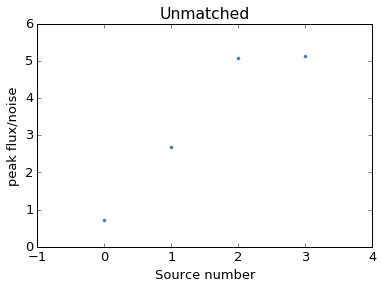

(3, 57, 64) float32


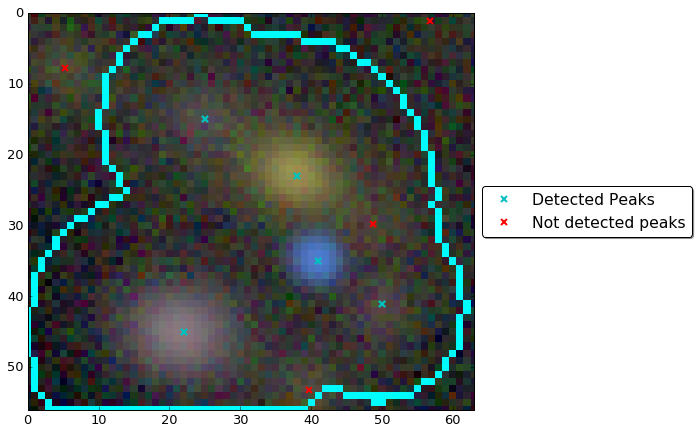

In [3]:
# Build a table of peaks detected by the pipeline
peakTable = sim.buildFootprintPeakTable(footprint, filters)
# Estimate the noise in the image
avgNoise = sim.getNoise(expDb.calexps)
simTable,idx, unmatchedTable = sim.matchFootprintToRef(footprint, peakTable, expDb.simTable,
                                                        filters,avgNoise=avgNoise, expDb=expDb,)
# Calculate the flux for isolated (non-blended) sources
sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable, avgNoise)

In [4]:
%time dbr = sim.deblendFootprintOld(filters, expDb, footprint, peakTable)

CPU times: user 60.5 ms, sys: 3.13 ms, total: 63.6 ms
Wall time: 62.4 ms


(3, 57, 64) float32


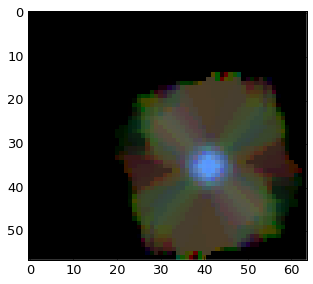

(3, 57, 64) float32


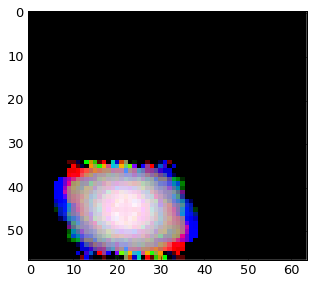

(3, 57, 64) float32


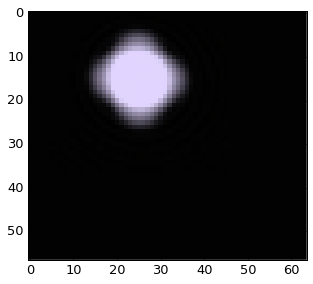

(3, 57, 64) float32


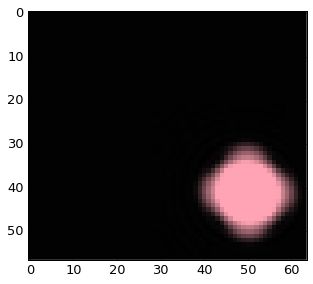

(3, 57, 64) float32


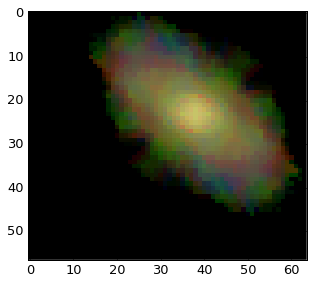

In [5]:
oldTemplates = sim.getODBTemplates(footprint, dbr)

In [6]:
simTemplates = sim.getSimTemplates(simTable, filters)

(3, 57, 64) float32


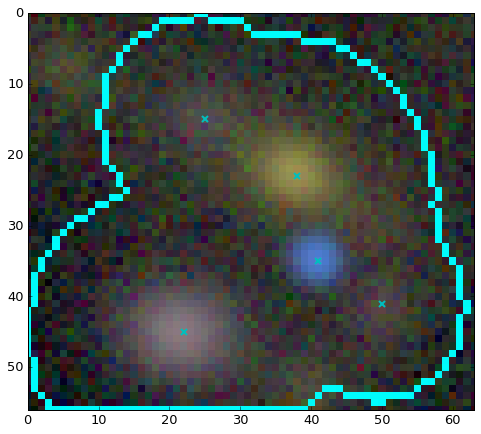

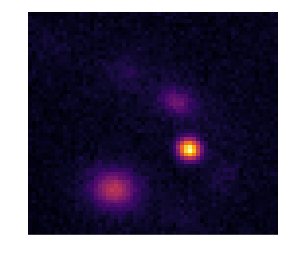

INFO:lsst.meas.deblender.proximal:constraints: MS
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 65
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 65
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 65
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 65
INFO:lsst.meas.deblender.proximal_nmf:Total psf pixels: 65
INFO:lsst.meas.deblender.proximal_nmf:Shape: (57, 64)
INFO:lsst.meas.deblender.proximal_nmf:Norm2: [ 69.17488729  85.41662602]
INFO:lsst.meas.deblender.proximal_nmf:Beginning Loop
INFO:lsst.meas.deblender.proximal_nmf:499 iterations
INFO:lsst.meas.deblender.proximal:Filter g
INFO:lsst.meas.deblender.proximal:Pixel range: -2.3120548725128174 to 42.17294692993164
INFO:lsst.meas.deblender.proximal:Max difference: 3.29494509021276
INFO:lsst.meas.deblender.proximal:Residual difference 0.7%
INFO:lsst.meas.deblender.proximal:Filter r
INFO:lsst.meas.deblender.proximal:Pixel range: -2.3120548725128174 to 42.17294692993164
INFO:lsst.meas.deblender.proximal:

(3, 57, 64) float32


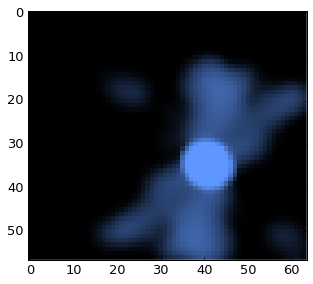

(3, 57, 64) float32


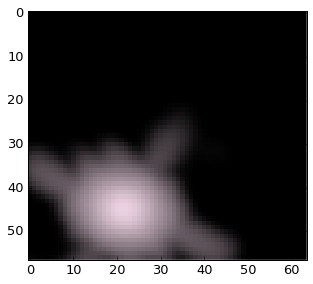

(3, 57, 64) float32


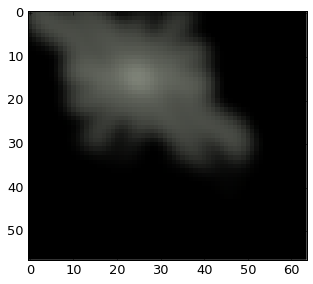

(3, 57, 64) float32


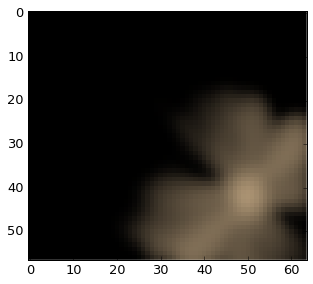

(3, 57, 64) float32


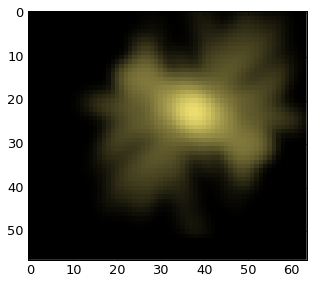

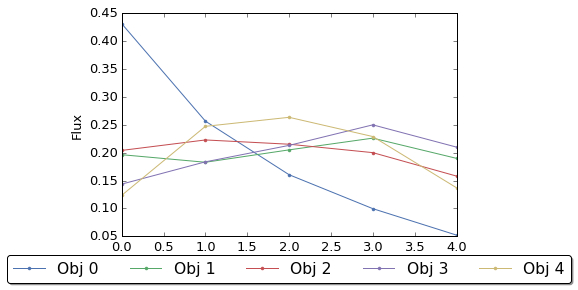

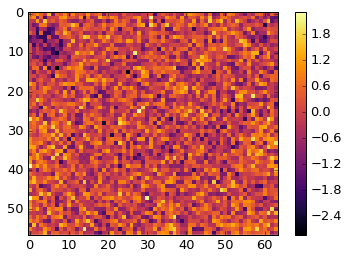

CPU times: user 20.4 s, sys: 427 ms, total: 20.9 s
Wall time: 20.9 s


In [7]:
peakCoords = np.array([simTable["x"]+.5,simTable["y"]]).T
#from astropy.table import vstack
#tbl = vstack([simTable, unmatchedTable])
#peakCoords = np.array([tbl["x"]+.5,tbl["y"]]).T
%time glmm = expDb.deblendParent(condition=condition, parentIdx=pidx, display=True, maxiter=500, constraints='MS', usePsf=True, psfThresh=3e-3, e_rel=1e-2, monotonicUseNearest=False, peakCoords=peakCoords, l0_thresh=.05)

INFO:lsst.meas.deblender:Old Deblender Comparison


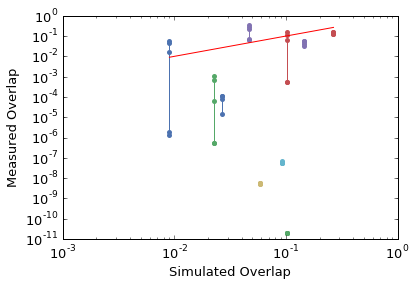

INFO:lsst.meas.deblender:Overlap between 0 and 1


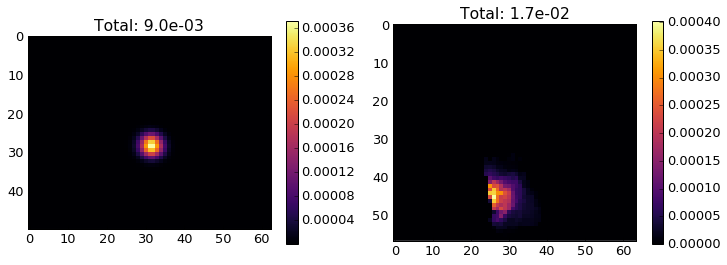

INFO:lsst.meas.deblender:Overlap between 0 and 2


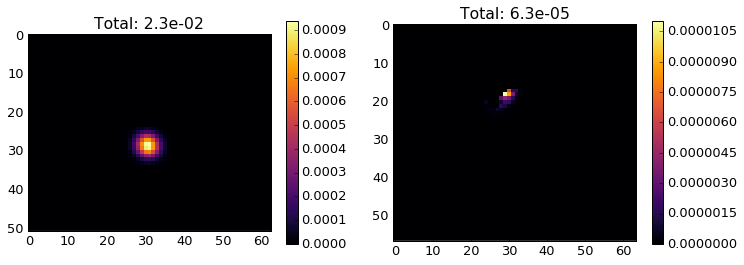

INFO:lsst.meas.deblender:Overlap between 0 and 3


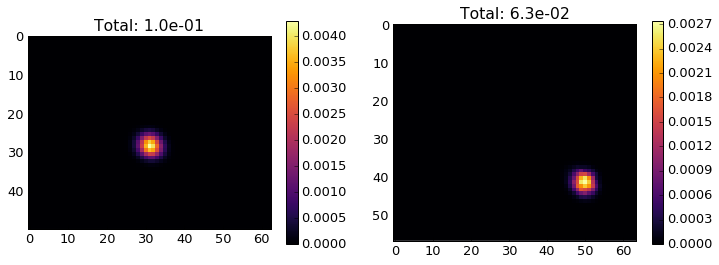

INFO:lsst.meas.deblender:Overlap between 0 and 4


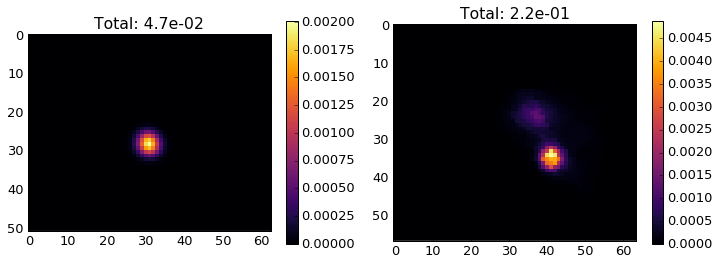

INFO:lsst.meas.deblender:Overlap between 1 and 2


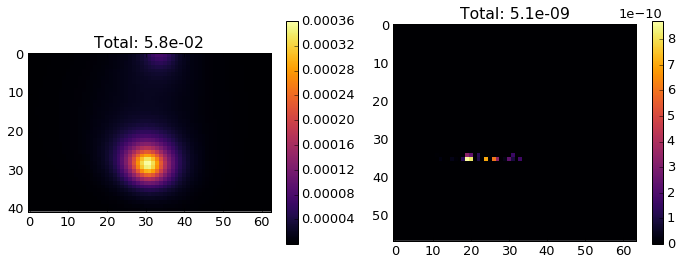

INFO:lsst.meas.deblender:Overlap between 1 and 3


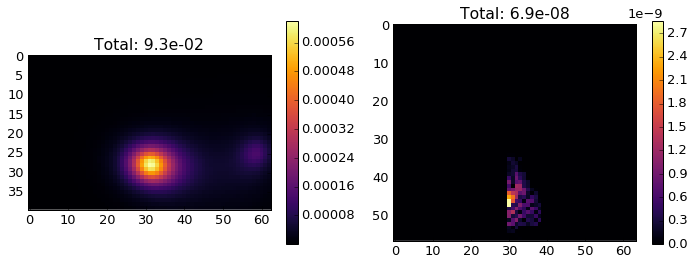

INFO:lsst.meas.deblender:Overlap between 1 and 4


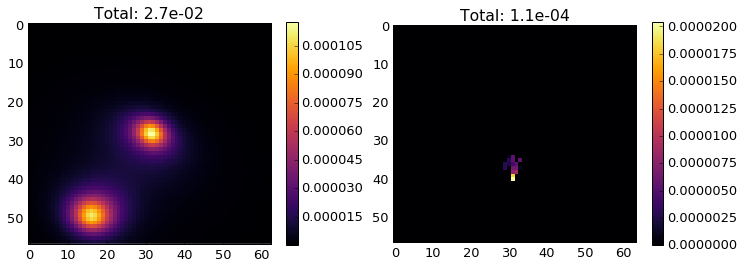

INFO:lsst.meas.deblender:Overlap between 2 and 3


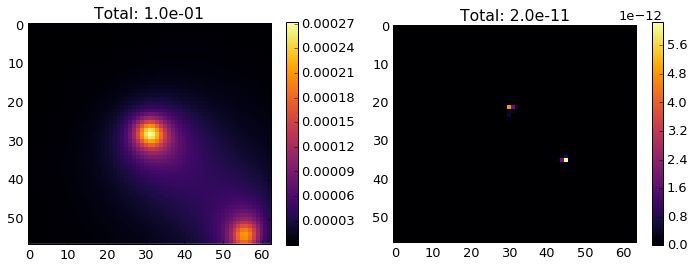

INFO:lsst.meas.deblender:Overlap between 2 and 4


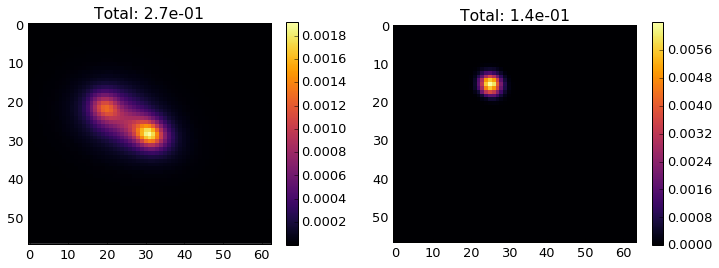

INFO:lsst.meas.deblender:Overlap between 3 and 4


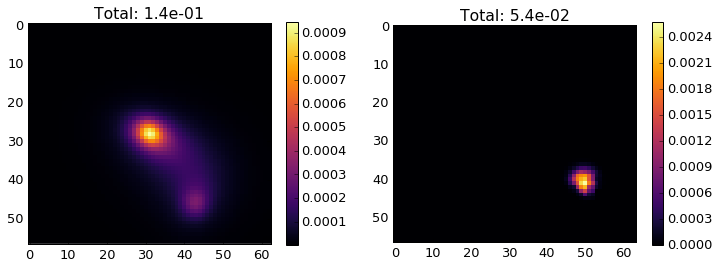

In [8]:
debTemplates = glmm.getAllTemplates()
logger.info("Old Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, oldTemplates, show=True)

INFO:lsst.meas.deblender:NMF Deblender Comparison


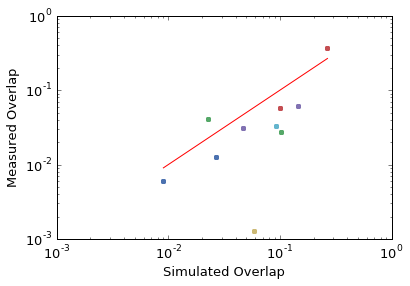

INFO:lsst.meas.deblender:Overlap between 0 and 1


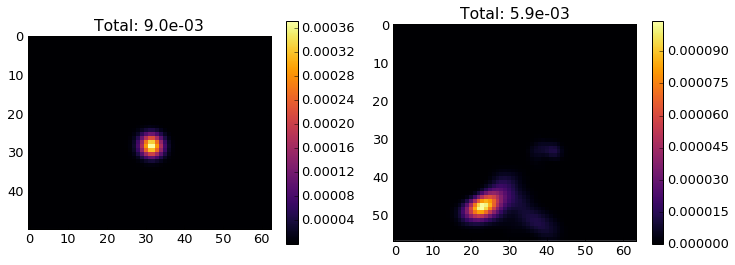

INFO:lsst.meas.deblender:Overlap between 0 and 2


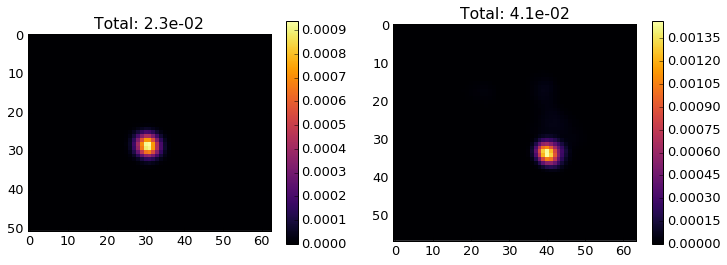

INFO:lsst.meas.deblender:Overlap between 0 and 3


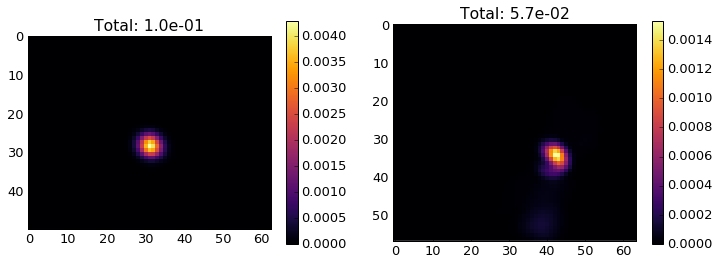

INFO:lsst.meas.deblender:Overlap between 0 and 4


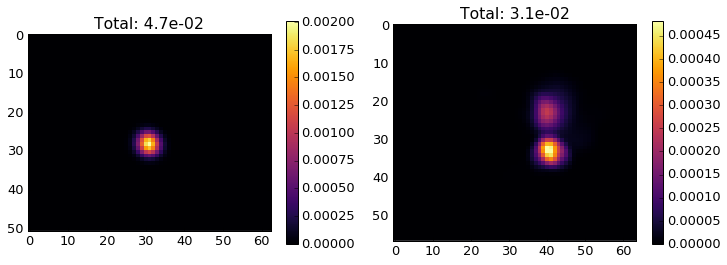

INFO:lsst.meas.deblender:Overlap between 1 and 2


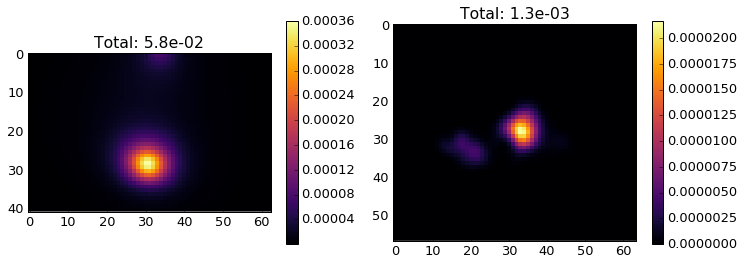

INFO:lsst.meas.deblender:Overlap between 1 and 3


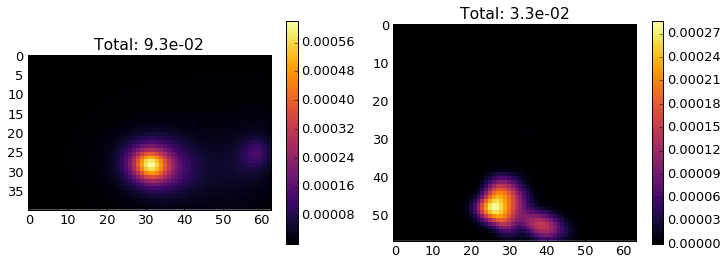

INFO:lsst.meas.deblender:Overlap between 1 and 4


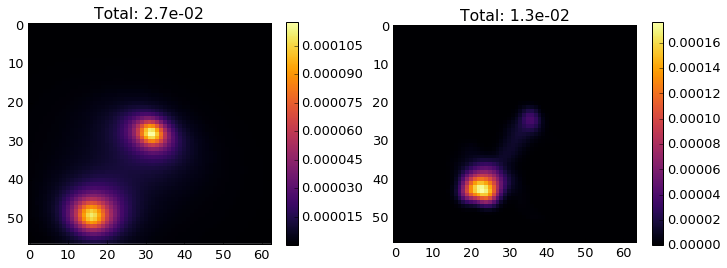

INFO:lsst.meas.deblender:Overlap between 2 and 3


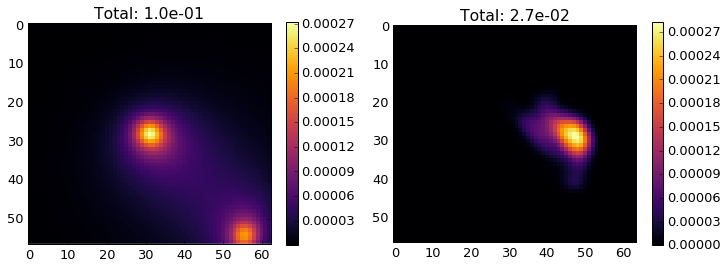

INFO:lsst.meas.deblender:Overlap between 2 and 4


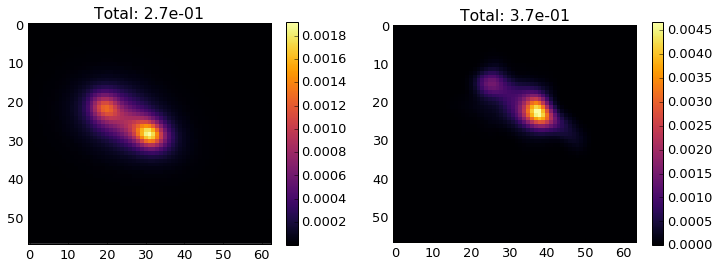

INFO:lsst.meas.deblender:Overlap between 3 and 4


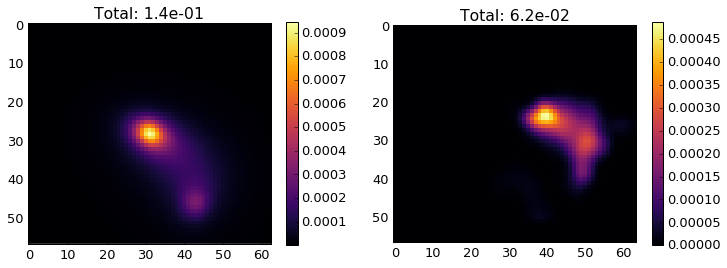

In [9]:
logger.info("NMF Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, debTemplates, show=True)

(3, 57, 64) float32


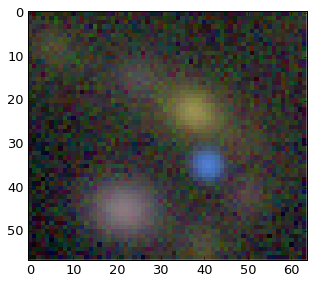

(3, 57, 64) float32


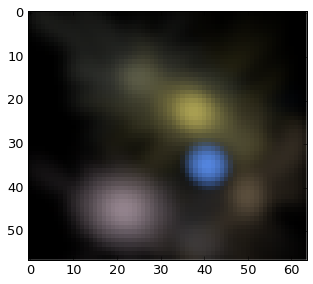

In [10]:
display.plotColorImage(np.array([calexp[footprint.getBBox()].getMaskedImage().getImage().getArray() for calexp in expDb.calexps]));
display.plotColorImage(glmm.model);

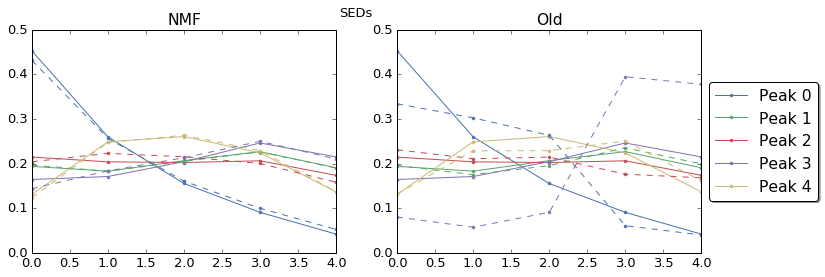

In [11]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
display.compareSeds([simTable, glmm.seds], filters, ax=ax1, show=False)
display.compareSeds([simTable, peakTable], filters, ax=ax2, show=False)
fig.suptitle("SEDs")
ax1.set_title("NMF")
ax2.set_title("Old")
plt.legend(loc="center left", fancybox=True, shadow=True, ncol=1, bbox_to_anchor=(1, 0.5))
plt.show()

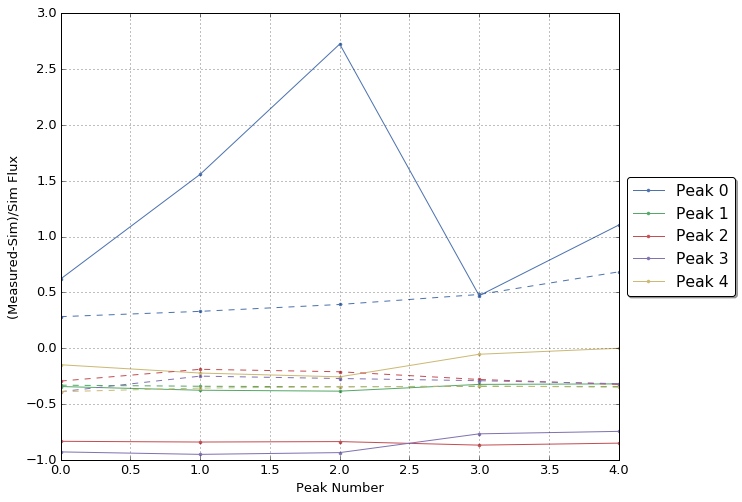

In [17]:
nmfPeakTable = peakTable.copy()
for pk, peak in enumerate(nmfPeakTable):
    for fidx, f in enumerate(expDb.filters):
        template = glmm.getTemplate(fidx, peak["peakIdx"])
        nmfPeakTable["flux_"+f][pk] = np.sum(template)

display.plotFluxDifference([peakTable, nmfPeakTable], simTable, filters, ax=None, show=True, color_cycle=None)

(3, 50, 75) float32


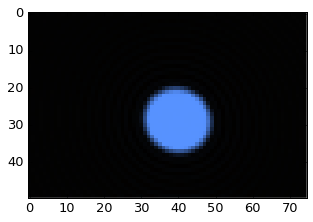

(3, 50, 75) float32


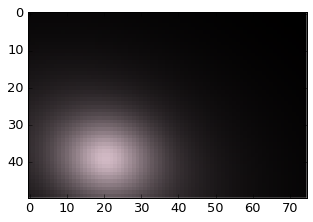

(3, 50, 75) float32


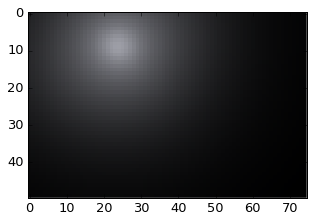

(3, 50, 75) float32


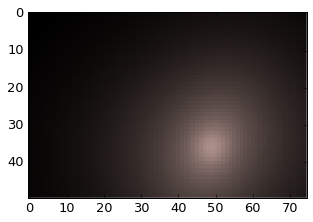

(3, 50, 75) float32


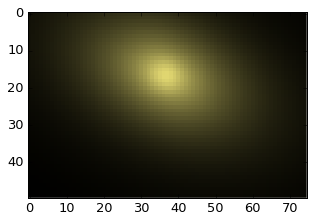

In [18]:
for pk in range(len(simTable)):
    img = np.array([simTable["intensity_{0}".format(f)][pk].reshape(251,251)[200:250,75:150] for f in filters])
    display.plotColorImage(img)